In [32]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


In [4]:
train_path = "../train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[1], 'rb') as f:
    training_sample = pickle.load(f)

# LSTM

In [34]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        #print(x.size())
        #print(x.size(-1))
        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, h_t
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

In [6]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [35]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        dat = np.concatenate((inp, out), axis=0)
        
        train_data = []
        window_size = 20
        interval = 7
        for i in range(0, len(dat), interval):
            #print(len(dat[i:i+input_length]))
            if i + window_size < len(dat): 
                train_data.append(dat[i:i+window_size])
            
        #print(len(train_data))
        #print(train_data)
        
        input_seq = []
        target_seq = []
        for i in range(len(train_data)):
            input_seq.append(train_data[i][:-1])
            target_seq.append(train_data[i][1:])
        
        #print(input_seq)
        
        input_seq = np.array(input_seq, dtype=np.float32)
        target_seq = np.array(target_seq, dtype=np.float32)
        
        #print(input_seq.shape)
        #print(target_seq.shape)
        
        # Convert to float torch tensor
        #return torch.from_numpy(inp).float(), torch.from_numpy(out).float() #torch.from_numpy(out[:,:2]).float()
        return torch.from_numpy(input_seq).float(), torch.from_numpy(target_seq).float()

In [36]:
training_sample['p_out'].shape

(60, 30, 2)

In [37]:
training_sample['v_out'].shape

(60, 30, 2)

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [38]:
# batch_size = 64
interval = 7 # sampling interval for LSTM
window_size = 20 # number of timesteps to take as input
batch_size = 512
#in_dim = 19*4 # MLP
#out_dim = 4 #30*2 # MLP
input_size = 4 # LSTM
output_size = 4 # LSTM (has to match input_size)
hidden_dim = 256 #128 #32 #128
num_layers = 1 #3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [39]:
train_path = "../train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [40]:
len(train_set)

180000

In [80]:
# train_set[0]

In [41]:
len(train_loader)

352

# Model, Loss Function and Optimizer

In [42]:
# # RNN, LSTM, 1dCNN, Transformer
# model = MLPNet(in_dim = in_dim, 
#                out_dim = out_dim,
#                hidden_dim = hidden_dim, 
#                num_layers = num_layers).to(device) # move model to gpu 

model = MyLSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=num_layers).to(device)

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [9]:
model.load_state_dict(torch.load('baseline.pt'))

<All keys matched successfully>

In [118]:
# train_path = "./train/train/"
# train_pkl_list = glob(os.path.join(train_path, '*'))
# train_pkl_list.sort()

# train_preds = []
# for idx in range(3):
#     with open(train_pkl_list[idx], 'rb') as f:
#         train_sample = pickle.load(f)
#         pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
#         inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

#         # Normalization 
#         min_vecs = np.min(inp_scene, axis = (0,1))
#         max_vecs = np.max(inp_scene, axis = (0,1))
        
#         inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
#         inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

#         preds = model(inp).cpu().data.numpy()
        
#         # De-Normalization ! 
#         preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
#         train_preds.append(preds)

# Training

In [171]:
for inp, tgt in train_loader:
    print(inp.shape)
    print(tgt.shape)
    print(inp.view(-1, window_size-1, 4).size()) 
    print(inp[0, 0, :, :])
    break
        

torch.Size([512, 5, 19, 4])
torch.Size([512, 5, 19, 4])
torch.Size([2560, 19, 4])
tensor([[1.0000, 1.0000, 0.0566, 0.0473],
        [0.9998, 0.9996, 0.0643, 0.0610],
        [0.9995, 0.9992, 0.0543, 0.0229],
        [0.9993, 0.9988, 0.1135, 0.1166],
        [0.9991, 0.9984, 0.0722, 0.0608],
        [0.9989, 0.9981, 0.1136, 0.1087],
        [0.9987, 0.9977, 0.0845, 0.0779],
        [0.9984, 0.9973, 0.0762, 0.0627],
        [0.9982, 0.9969, 0.0633, 0.0508],
        [0.9980, 0.9965, 0.0501, 0.0407],
        [0.9978, 0.9962, 0.1454, 0.1404],
        [0.9975, 0.9957, 0.0430, 0.0333],
        [0.9973, 0.9954, 0.1270, 0.1274],
        [0.9971, 0.9950, 0.0749, 0.0670],
        [0.9969, 0.9946, 0.0619, 0.0524],
        [0.9966, 0.9942, 0.0747, 0.0485],
        [0.9964, 0.9938, 0.0602, 0.0563],
        [0.9962, 0.9935, 0.1179, 0.1185],
        [0.9959, 0.9930, 0.0306, 0.0269]])


In [43]:
def train_epoch(train_loader, model, optimizer, loss_function):

    train_mse = []
    for inp, tgt in tqdm(train_loader):
        
        inp = inp.view(-1, window_size-1, 4)
        tgt = tgt.view(-1, window_size-1, 4)
        
        #print(inp.size())
        
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        output, hidden = model(inp)
        output = output.to(device)
        #print(output.shape)
        #print(hidden.shape)
        #print(tgt.view(-1, 4).size())
        
        loss = loss_function(output, tgt.view(-1, 4))
        train_mse.append(loss.item()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    
    valid_mse = []
    #preds = []
    #trues = []
    
    with torch.no_grad():
        for inp, tgt in valid_loader:
            
            inp = inp.view(-1, window_size-1, 4)
            tgt = tgt.view(-1, window_size-1, 4)
            
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            output, hidden = model(inp)
            output = output.to(device)
                    
            loss = loss_function(output, tgt.view(-1, 4))
            
            #preds.append(pred.cpu().data.numpy())
            #trues.append(tgt.cpu().data.numpy())
            
            valid_mse.append(loss.item())
            
        #preds = np.concatenate(preds, axis = 0)  
        #trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse#, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [44]:
len(train_pkl_lst)

205942

 44%|████▍     | 155/352 [01:54<02:39,  1.24it/s]


 88%|████████▊ | 309/352 [04:26<00:47,  1.10s/it]


100%|██████████| 352/352 [05:18<00:00,  1.10it/s]


[0.21745]
0.11777
Epoch 1 | T: 6.30 | Train RMSE: 0.21745 | Valid RMSE: 0.11777


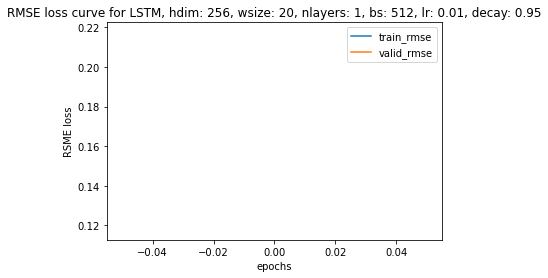

 44%|████▍     | 154/352 [02:13<02:44,  1.20it/s]


 88%|████████▊ | 308/352 [04:36<00:38,  1.13it/s]


100%|██████████| 352/352 [05:26<00:00,  1.08it/s]


[0.21745, 0.11508]
0.11393
Epoch 2 | T: 6.33 | Train RMSE: 0.11508 | Valid RMSE: 0.11393


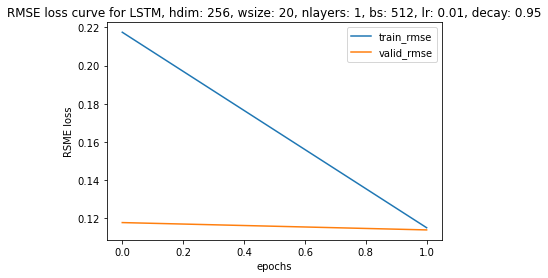

  2%|▏         | 7/352 [00:05<04:22,  1.31it/s]

In [ ]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    print(train_rmse)
    
    model.eval()
    val_rmse = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)
    print(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
        torch.save(best_model.state_dict(), f'lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')    
        break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for LSTM, hdim: {hidden_dim}, wsize: {window_size}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'lstm_loss_curve_v1_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    

# Evaluation and Submission

In [25]:
model.load_state_dict(torch.load('lstm_hdim_32_wsize_20_interval_7_nlayers_1_bs_512_lr_0.01_decay_0.95.pt'))
best_model = model

In [26]:
best_model

MyLSTM(
  (lstm): LSTM(4, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [24]:
test_path = "../val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        #print(min_vecs.shape)
        #print(max_vecs.shape)
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        #print(inp)
        # post-processing for LSTM
        predictions = [[]]
        inp_data = inp[0][-1]
        #print(inp_data.size())
        for i in range(30):
            preds = best_model(inp_data.reshape(1, 1, 4))
            predictions[0].append(preds[0].cpu().data.numpy()[0, :2])
            #print(preds)
            inp_data = preds[0]
            
#         print(inp[0][-1])
#         preds = best_model(inp)#.cpu().data.numpy()
#         print(preds)
#         print(inp.shape)
#         print(preds[0].shape)

        predictions = np.array(predictions)
        #print(predictions.shape)

        # De-Normalization ! 
        predictions = predictions * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(predictions)

In [25]:
print(test_preds[0].shape)
print(test_preds[0])

(1, 30, 2)
[[[1711.24461991  339.599696  ]
  [1708.99950078  342.39178537]
  [1707.06558524  344.7566902 ]
  [1705.39272282  346.76168501]
  [1703.93939887  348.46289735]
  [1702.67159015  349.90718381]
  [1701.5611      351.13394056]
  [1700.58441387  352.17628133]
  [1699.72186694  353.06208447]
  [1698.95733198  353.81504004]
  [1698.27665864  354.45517335]
  [1697.66829773  354.99939028]
  [1697.12226079  355.46217536]
  [1696.63001597  355.85567901]
  [1696.18448811  356.19026292]
  [1695.7798506   356.47480539]
  [1695.41058895  356.71678865]
  [1695.07222917  356.92256059]
  [1694.76133771  357.09757471]
  [1694.47458507  357.24641198]
  [1694.20874582  357.37304254]
  [1693.96205116  357.48078213]
  [1693.73200396  357.57246659]
  [1693.51693948  357.65047363]
  [1693.31529703  357.7168756 ]
  [1693.12572399  357.77346125]
  [1692.94707585  357.82164848]
  [1692.77841619  357.86272434]
  [1692.61849645  357.89773589]
  [1692.4670045   357.92764295]]]


# Generate Submission File

### Steps to create submission file 
Run the below cells. The last cell will generate a submission file "test_submission.csv" that you can submit to Kaggle.

In [26]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [27]:
# Save for later use
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv(f'test_submission_lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [30]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv('test_submission.csv', index=None)

In [31]:
sub_df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1711.244620,339.599696,1708.999501,342.391785,1707.065585,344.756690,1705.392723,346.761685,1703.939399,...,1693.125724,357.773461,1692.947076,357.821648,1692.778416,357.862724,1692.618496,357.897736,1692.467004,357.927643
1,10015,724.785839,1240.929961,724.170077,1250.371301,723.666634,1258.495345,723.257290,1265.484162,722.926780,...,722.613862,1306.364275,722.690189,1306.544594,722.767501,1306.694037,722.845573,1306.816982,722.924004,1306.916849
2,10019,573.966905,1252.100191,574.083810,1258.208111,574.184948,1263.295085,574.281661,1267.554346,574.378696,...,576.496260,1289.966765,576.577526,1290.050063,576.656367,1290.119294,576.732782,1290.176581,576.806842,1290.223573
3,10028,1692.978288,314.071388,1692.665880,313.127867,1691.663756,312.309126,1690.359604,311.608876,1688.907511,...,1661.880594,308.029418,1660.980254,308.026864,1660.110954,308.026394,1659.271484,308.027671,1658.460835,308.030319
4,1003,2121.928830,678.789964,2119.861912,679.308870,2117.877021,679.755910,2115.971597,680.141772,2114.142825,...,2089.661137,682.681280,2089.007355,682.703405,2088.388252,682.722910,2087.802037,682.740003,2087.247685,682.754934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,256.307767,804.455436,256.431982,803.494397,256.561905,802.691880,256.694981,802.018920,256.829658,...,259.364627,798.514890,259.460832,798.496667,259.554466,798.479610,259.645577,798.463621,259.734198,798.448411
3196,99,587.890855,1155.802464,587.922195,1156.824746,587.943984,1157.641455,587.962068,1158.299460,587.979391,...,588.506684,1160.904332,588.531705,1160.894859,588.556182,1160.884750,588.580222,1160.874359,588.603718,1160.863755
3197,9905,1755.480836,446.634373,1754.161551,448.729816,1752.537961,450.403170,1750.833643,451.769740,1749.135843,...,1725.823985,458.957692,1725.139273,459.000214,1724.479578,459.038146,1723.843743,459.072130,1723.230824,459.102699
3198,9910,576.053804,1290.611679,577.297222,1291.835656,578.458573,1292.818994,579.551766,1293.610183,580.586147,...,594.354339,1295.502707,594.763702,1295.412812,595.158185,1295.322287,595.538460,1295.231762,595.905163,1295.141394


In [ ]:
# Ensemble Method 